# Binary Classification for Diabetes
To classify structured data (e.g. tabular data in a CSV). We will use Keras to define the model, and feature columns as a bridge to map from columns in a CSV to features used to train the model. Steps to complete:

1. Load a CSV file using Pandas.
2. Build an input pipeline to batch and shuffle the rows using tf.data.
3. Map from columns in the CSV to features used to train the model using feature columns.
4. Build, train, and evaluate a model using Keras.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt # data visualization


csv_path = 'diabetes.csv'

# Any results you write to the current directory are saved as output.

In [4]:
#import sklearn
#from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
#from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [5]:
tf.random.set_seed(13)
mpl.style.use('seaborn-dark')

In [6]:
numeric_columns = ["Pregnancies",               # Number of times pregnant
                    "Glucose",                  # Plasma glucose concentration a 2 hours in an oral glucose tolerance test
                    "BloodPressure",            # Diastolic blood pressure (mm Hg)
                    "SkinThickness",            # Triceps skin fold thickness (mm)
                    "Insulin",                  # 2-Hour serum insulin (mu U/ml)
                    "BMI",                      # Body mass index (weight in kg/(height in m)^2)
                    "DiabetesPedigreeFunction", # Diabetes pedigree function
                    "Age"                       # Age (years)
                  ]
output = "Outcome" # Class variable (0 or 1) 268 of 768 are 1, the others are 0

## Use Pandas to create a dataframe
Pandas is a Python library with many helpful utilities for loading and working with structured data. We will use Pandas to download the dataset from disk, and load it into a dataframe.

In [7]:
df = pd.read_csv(csv_path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Examine the class label imbalance
Let's look at the dataset imbalance:

In [9]:
neg, pos = np.bincount(df['Outcome'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.3f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 768
    Positive: 268 (34.896% of total)



In [10]:
pos_demo = df[df['Outcome'] == 1].sample(34, random_state=13)
neg_demo = df[df['Outcome'] == 0].sample(34, random_state=13)
demo = pd.concat([pos_demo, neg_demo])
demo.to_csv("Demo.csv")

data = pd.concat([df, demo]).drop_duplicates(keep=False)
data.to_csv("Data.csv")

In [11]:
neg, pos = np.bincount(data['Outcome'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.3f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 700
    Positive: 234 (33.429% of total)



In [12]:
pos_test = data[data['Outcome'] == 1].sample(33, random_state=13)
neg_test = data[data['Outcome'] == 0].sample(67, random_state=13)
test = pd.concat([pos_test, neg_test])
test.to_csv("Test.csv")

train = pd.concat([data, test]).drop_duplicates(keep=False)
train.to_csv("Train.csv")

In [13]:
feature_columns = []

# numeric cols
for header in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(header))

In [14]:
# bucketized cols
age_buckets = tf.feature_column.bucketized_column(feature_columns[-1], boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85])
feature_columns.append(age_buckets)

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
    > $\frac{\text{true samples}}{\text{total samples}}$

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)

In [15]:
METRICS = [    
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),    
]

In [16]:
CALLBACKS = [tf.keras.callbacks.ModelCheckpoint("weights.hdf5", 
                                                monitor='val_loss',
                                                save_best_only=True, 
                                              save_freq='epoch'
                                               ),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=50, 
                                              restore_best_weights=True
                                             ),
             tf.keras.callbacks.TensorBoard(log_dir='logs', 
                                            histogram_freq=1, 
                                            write_graph=True, 
                                            write_images=True, 
                                            update_freq='epoch', 
                                            profile_batch=3                                            
                                           )
            ]

In [17]:
class DiaModel(tf.keras.Model):

  def __init__(self, output_bias = None):
    super(DiaModel, self).__init__()
    #self.input = tf.keras.layers.InputLayer(input_shape=(37, 100, 100, 3))
    self.feature_input = tf.keras.layers.DenseFeatures(feature_columns)
    
    # input layer on the HyperModel
    self.fc_0 = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0))
    # self.drop_0 = tf.keras.layers.Dropout(rate=0.5)
    
    self.fc_1 = tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    self.drop_1 = tf.keras.layers.Dropout(rate=0.3)
    self.fc_2 = tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.drop_2 = tf.keras.layers.Dropout(rate=0.5)
    self.fc_3 = tf.keras.layers.Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    self.drop_3 = tf.keras.layers.Dropout(rate=0.7)
    self.fc_4 = tf.keras.layers.Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.drop_4 = tf.keras.layers.Dropout(rate=0.6)
    self.fc_5 = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    self.drop_5 = tf.keras.layers.Dropout(rate=0.5)
    
    if output_bias:
        self.pred = tf.keras.layers.Dense(1,
                                          activation='sigmoid',
                                          name = 'pred',
                                          bias_initializer = tf.constant_initializer(value=output_bias))
    else:
        self.pred = tf.keras.layers.Dense(1, activation='sigmoid', name = 'pred')

  def call(self, inputs, training=False):
    x = self.feature_input(inputs)
    
    x = self.fc_0(x)
    
    x = self.fc_1(x)
    if training:
        x = self.drop_1(x)
    x = self.fc_2(x)
    if training:
        x = self.drop_2(x)
    x = self.fc_3(x)
    if training:
        x = self.drop_3(x)
    x = self.fc_4(x)
    if training:
        x = self.drop_4(x)
    x = self.fc_5(x)
    if training:
        x = self.drop_5(x)
    
    return self.pred(x)


In [18]:
model = DiaModel()

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), 
    loss=tf.keras.losses.BinaryCrossentropy(), # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = METRICS
             )

In [20]:
def df_to_dataset(dataframe, targets, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = targets.copy()
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [21]:
features = train[numeric_columns]
features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
2,8,183,64,0,0,23.3,0.672,32
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
6,3,78,50,32,88,31.0,0.248,26


In [22]:
labels = train["Outcome"]
labels.head()

0    1
2    1
4    1
5    0
6    1
Name: Outcome, dtype: int64

In [23]:
def plot_metrics(history, n, epochs=100):
    acc = history["accuracy"]
    val_acc = history["val_accuracy"]
    
    loss = history["loss"]
    val_loss = history["val_loss"]
    
    epochs_range = range(epochs)
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'hspace': 0.3})
    
    ax[0].plot(epochs_range, acc, label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, label='Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    
    ax[1].plot(epochs_range, loss, label='Training Loss')
    ax[1].plot(epochs_range, val_loss, label='Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Training and Validation Loss')
    
    fig.savefig("fold-{}".format(n), dpi=fig.dpi)
    plt.show()
    plt.close()
    
    

Epoch 1/600

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 3s 3s/step - loss: 5.2015 - accuracy: 0.4180 - val_loss: 1.4065 - val_accuracy: 0.3600
Epoch 2/600
1/1 [==============================] - 1s 648ms/step - loss: 3.5601 - accuracy: 0.4920 - val_loss: 1.3624 - val_accuracy: 0.5600
Epoch 3/600
1/1 [==============================] - 1s 520ms/step - loss: 3.0119 - accuracy: 0.4980 - val_loss: 1.3412 - val_accuracy: 0.6800
Epoch 4/600
1/1 [==============================] - 1s 598ms/step - loss: 1.6804 - accura

1/1 [==============================] - 1s 540ms/step - loss: 0.8514 - accuracy: 0.6660 - val_loss: 0.8488 - val_accuracy: 0.6600
Epoch 53/600
1/1 [==============================] - 1s 596ms/step - loss: 0.8492 - accuracy: 0.6660 - val_loss: 0.8443 - val_accuracy: 0.6600
Epoch 54/600
1/1 [==============================] - 1s 621ms/step - loss: 0.8435 - accuracy: 0.6660 - val_loss: 0.8400 - val_accuracy: 0.6600
Epoch 55/600
1/1 [==============================] - 1s 548ms/step - loss: 0.8371 - accuracy: 0.6660 - val_loss: 0.8358 - val_accuracy: 0.6600
Epoch 56/600
1/1 [==============================] - 1s 524ms/step - loss: 0.8336 - accuracy: 0.6660 - val_loss: 0.8316 - val_accuracy: 0.6600
Epoch 57/600
1/1 [==============================] - 1s 689ms/step - loss: 0.8295 - accuracy: 0.6660 - val_loss: 0.8276 - val_accuracy: 0.6600
Epoch 58/600
1/1 [==============================] - 1s 596ms/step - loss: 0.8277 - accuracy: 0.6660 - val_loss: 0.8238 - val_accuracy: 0.6600
Epoch 59/600
1/1 [=

Epoch 110/600
1/1 [==============================] - 1s 672ms/step - loss: 0.7084 - accuracy: 0.6660 - val_loss: 0.7139 - val_accuracy: 0.6600
Epoch 111/600
1/1 [==============================] - 1s 636ms/step - loss: 0.7092 - accuracy: 0.6660 - val_loss: 0.7128 - val_accuracy: 0.6600
Epoch 112/600
1/1 [==============================] - 1s 615ms/step - loss: 0.7103 - accuracy: 0.6660 - val_loss: 0.7118 - val_accuracy: 0.6600
Epoch 113/600
1/1 [==============================] - 1s 625ms/step - loss: 0.7111 - accuracy: 0.6660 - val_loss: 0.7108 - val_accuracy: 0.6600
Epoch 114/600
1/1 [==============================] - 1s 546ms/step - loss: 0.7061 - accuracy: 0.6660 - val_loss: 0.7098 - val_accuracy: 0.6600
Epoch 115/600
1/1 [==============================] - 1s 668ms/step - loss: 0.7095 - accuracy: 0.6660 - val_loss: 0.7088 - val_accuracy: 0.6600
Epoch 116/600
1/1 [==============================] - 1s 664ms/step - loss: 0.7046 - accuracy: 0.6660 - val_loss: 0.7078 - val_accuracy: 0.6600

1/1 [==============================] - 1s 684ms/step - loss: 0.6736 - accuracy: 0.6660 - val_loss: 0.6746 - val_accuracy: 0.6600
Epoch 168/600
1/1 [==============================] - 1s 828ms/step - loss: 0.6693 - accuracy: 0.6660 - val_loss: 0.6742 - val_accuracy: 0.6600
Epoch 169/600
1/1 [==============================] - 1s 927ms/step - loss: 0.6715 - accuracy: 0.6660 - val_loss: 0.6738 - val_accuracy: 0.6600
Epoch 170/600
1/1 [==============================] - 1s 765ms/step - loss: 0.6727 - accuracy: 0.6660 - val_loss: 0.6734 - val_accuracy: 0.6600
Epoch 171/600
1/1 [==============================] - 1s 907ms/step - loss: 0.6708 - accuracy: 0.6660 - val_loss: 0.6730 - val_accuracy: 0.6600
Epoch 172/600
1/1 [==============================] - 1s 810ms/step - loss: 0.6699 - accuracy: 0.6660 - val_loss: 0.6726 - val_accuracy: 0.6600
Epoch 173/600
1/1 [==============================] - 1s 896ms/step - loss: 0.6685 - accuracy: 0.6660 - val_loss: 0.6721 - val_accuracy: 0.6600
Epoch 174/600

1/1 [==============================] - 1s 684ms/step - loss: 0.6556 - accuracy: 0.6660 - val_loss: 0.6575 - val_accuracy: 0.6600
Epoch 225/600
1/1 [==============================] - 1s 662ms/step - loss: 0.6548 - accuracy: 0.6660 - val_loss: 0.6569 - val_accuracy: 0.6600
Epoch 226/600
1/1 [==============================] - 1s 672ms/step - loss: 0.6526 - accuracy: 0.6660 - val_loss: 0.6561 - val_accuracy: 0.6600
Epoch 227/600
1/1 [==============================] - 1s 716ms/step - loss: 0.6590 - accuracy: 0.6680 - val_loss: 0.6560 - val_accuracy: 0.6600
Epoch 228/600
1/1 [==============================] - 1s 709ms/step - loss: 0.6537 - accuracy: 0.6660 - val_loss: 0.6558 - val_accuracy: 0.6600
Epoch 229/600
1/1 [==============================] - 1s 610ms/step - loss: 0.6525 - accuracy: 0.6640 - val_loss: 0.6554 - val_accuracy: 0.6600
Epoch 230/600
1/1 [==============================] - 1s 705ms/step - loss: 0.6578 - accuracy: 0.6660 - val_loss: 0.6550 - val_accuracy: 0.6600
Epoch 231/600

1/1 [==============================] - 1s 870ms/step - loss: 0.6474 - accuracy: 0.6660 - val_loss: 0.6434 - val_accuracy: 0.6600
Epoch 282/600
1/1 [==============================] - 1s 663ms/step - loss: 0.6424 - accuracy: 0.6660 - val_loss: 0.6422 - val_accuracy: 0.6600
Epoch 283/600
1/1 [==============================] - 1s 772ms/step - loss: 0.6541 - accuracy: 0.6660 - val_loss: 0.6415 - val_accuracy: 0.6600
Epoch 284/600
1/1 [==============================] - 1s 535ms/step - loss: 0.6473 - accuracy: 0.6680 - val_loss: 0.6412 - val_accuracy: 0.6600
Epoch 285/600
1/1 [==============================] - 1s 706ms/step - loss: 0.6478 - accuracy: 0.6660 - val_loss: 0.6411 - val_accuracy: 0.6600
Epoch 286/600
1/1 [==============================] - 1s 799ms/step - loss: 0.6491 - accuracy: 0.6660 - val_loss: 0.6412 - val_accuracy: 0.6600
Epoch 287/600
1/1 [==============================] - 1s 714ms/step - loss: 0.6343 - accuracy: 0.6660 - val_loss: 0.6415 - val_accuracy: 0.6600
Epoch 288/600

1/1 [==============================] - 1s 904ms/step - loss: 0.6394 - accuracy: 0.6660 - val_loss: 0.6332 - val_accuracy: 0.6600
Epoch 339/600
1/1 [==============================] - 1s 676ms/step - loss: 0.6290 - accuracy: 0.6660 - val_loss: 0.6326 - val_accuracy: 0.6600
Epoch 340/600
1/1 [==============================] - 1s 672ms/step - loss: 0.6214 - accuracy: 0.6660 - val_loss: 0.6324 - val_accuracy: 0.6600
Epoch 341/600
1/1 [==============================] - 1s 612ms/step - loss: 0.6379 - accuracy: 0.6600 - val_loss: 0.6326 - val_accuracy: 0.6600
Epoch 342/600
1/1 [==============================] - 1s 982ms/step - loss: 0.6341 - accuracy: 0.6620 - val_loss: 0.6325 - val_accuracy: 0.6600
Epoch 343/600
1/1 [==============================] - 1s 631ms/step - loss: 0.6317 - accuracy: 0.6660 - val_loss: 0.6321 - val_accuracy: 0.6600
Epoch 344/600
1/1 [==============================] - 1s 685ms/step - loss: 0.6236 - accuracy: 0.6660 - val_loss: 0.6320 - val_accuracy: 0.6600
Epoch 345/600

1/1 [==============================] - 1s 835ms/step - loss: 0.6139 - accuracy: 0.6640 - val_loss: 0.6269 - val_accuracy: 0.6600
Epoch 396/600
1/1 [==============================] - 1s 701ms/step - loss: 0.6415 - accuracy: 0.6700 - val_loss: 0.6271 - val_accuracy: 0.6600
Epoch 397/600
1/1 [==============================] - 1s 563ms/step - loss: 0.6091 - accuracy: 0.6620 - val_loss: 0.6265 - val_accuracy: 0.6600
Epoch 398/600
1/1 [==============================] - 1s 620ms/step - loss: 0.6170 - accuracy: 0.6680 - val_loss: 0.6238 - val_accuracy: 0.6600
Epoch 399/600
1/1 [==============================] - 1s 681ms/step - loss: 0.6162 - accuracy: 0.6660 - val_loss: 0.6220 - val_accuracy: 0.6600
Epoch 400/600
1/1 [==============================] - 1s 764ms/step - loss: 0.6125 - accuracy: 0.6640 - val_loss: 0.6216 - val_accuracy: 0.6600
Epoch 401/600
1/1 [==============================] - 1s 566ms/step - loss: 0.6351 - accuracy: 0.6740 - val_loss: 0.6211 - val_accuracy: 0.6600
Epoch 402/600

1/1 [==============================] - 1s 677ms/step - loss: 0.6115 - accuracy: 0.6780 - val_loss: 0.6068 - val_accuracy: 0.6600
Epoch 453/600
1/1 [==============================] - 0s 473ms/step - loss: 0.6153 - accuracy: 0.6960 - val_loss: 0.6083 - val_accuracy: 0.6600
Epoch 454/600
1/1 [==============================] - 1s 604ms/step - loss: 0.6149 - accuracy: 0.6780 - val_loss: 0.6087 - val_accuracy: 0.6600
Epoch 455/600
1/1 [==============================] - 1s 629ms/step - loss: 0.6025 - accuracy: 0.6800 - val_loss: 0.6086 - val_accuracy: 0.6600
Epoch 456/600
1/1 [==============================] - 1s 546ms/step - loss: 0.6057 - accuracy: 0.6760 - val_loss: 0.6091 - val_accuracy: 0.6600
Epoch 457/600
1/1 [==============================] - 1s 609ms/step - loss: 0.6233 - accuracy: 0.6700 - val_loss: 0.6080 - val_accuracy: 0.6600
Epoch 458/600
1/1 [==============================] - 1s 798ms/step - loss: 0.6052 - accuracy: 0.6740 - val_loss: 0.6054 - val_accuracy: 0.6600
Epoch 459/600

1/1 [==============================] - 1s 866ms/step - loss: 0.6000 - accuracy: 0.7040 - val_loss: 0.6057 - val_accuracy: 0.6900
Epoch 510/600
1/1 [==============================] - 1s 837ms/step - loss: 0.6168 - accuracy: 0.6700 - val_loss: 0.6057 - val_accuracy: 0.6700
Epoch 511/600
1/1 [==============================] - 1s 868ms/step - loss: 0.6143 - accuracy: 0.6840 - val_loss: 0.6060 - val_accuracy: 0.6600
Epoch 512/600
1/1 [==============================] - 1s 636ms/step - loss: 0.5941 - accuracy: 0.7060 - val_loss: 0.6061 - val_accuracy: 0.6600
Epoch 513/600
1/1 [==============================] - 1s 901ms/step - loss: 0.6243 - accuracy: 0.6660 - val_loss: 0.6035 - val_accuracy: 0.6600
Epoch 514/600
1/1 [==============================] - 0s 474ms/step - loss: 0.5898 - accuracy: 0.7080 - val_loss: 0.6023 - val_accuracy: 0.6700
Epoch 515/600
1/1 [==============================] - 1s 791ms/step - loss: 0.5947 - accuracy: 0.6900 - val_loss: 0.5979 - val_accuracy: 0.7000
Epoch 516/600

1/1 [==============================] - 1s 669ms/step - loss: 0.5960 - accuracy: 0.6840 - val_loss: 0.5729 - val_accuracy: 0.7300
Epoch 567/600
1/1 [==============================] - 1s 816ms/step - loss: 0.5961 - accuracy: 0.6960 - val_loss: 0.5755 - val_accuracy: 0.7300
Epoch 568/600
1/1 [==============================] - 1s 674ms/step - loss: 0.5739 - accuracy: 0.7320 - val_loss: 0.5773 - val_accuracy: 0.7400
Epoch 569/600
1/1 [==============================] - 1s 637ms/step - loss: 0.5772 - accuracy: 0.6900 - val_loss: 0.5776 - val_accuracy: 0.7300
Epoch 570/600
1/1 [==============================] - 1s 691ms/step - loss: 0.5791 - accuracy: 0.7100 - val_loss: 0.5778 - val_accuracy: 0.6900
Epoch 571/600
1/1 [==============================] - 1s 640ms/step - loss: 0.5859 - accuracy: 0.6960 - val_loss: 0.5773 - val_accuracy: 0.6900
Epoch 572/600
1/1 [==============================] - 1s 677ms/step - loss: 0.5699 - accuracy: 0.7020 - val_loss: 0.5761 - val_accuracy: 0.6900
Epoch 573/600

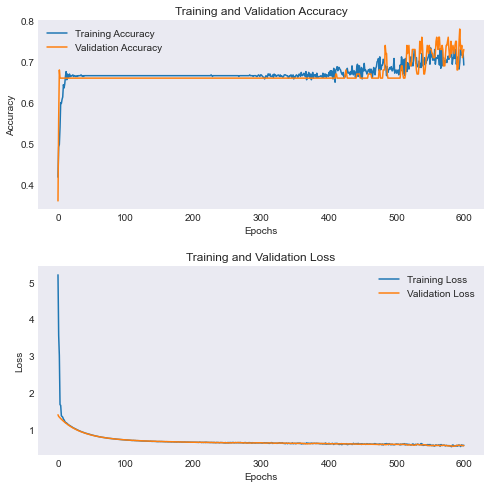

1/1 [==============================] - 0s 14ms/step - loss: 0.5385 - accuracy: 0.7100


[+] {'loss': 0.5385415554046631, 'accuracy': 0.7099999785423279} 


Epoch 1/600
1/1 [==============================] - 1s 1s/step - loss: 0.5550 - accuracy: 0.7120 - val_loss: 0.5410 - val_accuracy: 0.7300
Epoch 2/600
1/1 [==============================] - 1s 742ms/step - loss: 0.5755 - accuracy: 0.7140 - val_loss: 0.5442 - val_accuracy: 0.7100
Epoch 3/600
1/1 [==============================] - 1s 966ms/step - loss: 0.5629 - accuracy: 0.7300 - val_loss: 0.5442 - val_accuracy: 0.7200
Epoch 4/600
1/1 [==============================] - 1s 769ms/step - loss: 0.5660 - accuracy: 0.7180 - val_loss: 0.5417 - val_accuracy: 0.7200
Epoch 5/600
1/1 [==============================] - 1s 593ms/step - loss: 0.5738 - accuracy: 0.7160 - val_loss: 0.5425 - val_accuracy: 0.7100
Epoch 6/600
1/1 [==============================] - 1s 796ms/step - loss: 0.5596 - accuracy: 0.7420 - val_loss: 0.5500 - val_accuracy: 0.7200
E

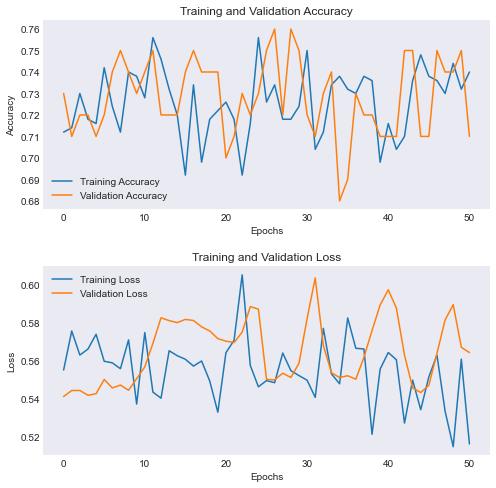

1/1 [==============================] - 0s 4ms/step - loss: 0.5435 - accuracy: 0.7700


[+] {'loss': 0.543521523475647, 'accuracy': 0.7699999809265137} 


Epoch 1/600
1/1 [==============================] - 1s 1s/step - loss: 0.5604 - accuracy: 0.7160 - val_loss: 0.5305 - val_accuracy: 0.7500
Epoch 2/600
1/1 [==============================] - 1s 545ms/step - loss: 0.5514 - accuracy: 0.7440 - val_loss: 0.5218 - val_accuracy: 0.7500
Epoch 3/600
1/1 [==============================] - 1s 1s/step - loss: 0.5804 - accuracy: 0.7320 - val_loss: 0.5151 - val_accuracy: 0.7300
Epoch 4/600
1/1 [==============================] - 1s 801ms/step - loss: 0.5518 - accuracy: 0.7100 - val_loss: 0.5163 - val_accuracy: 0.7400
Epoch 5/600
1/1 [==============================] - 1s 1s/step - loss: 0.5581 - accuracy: 0.7260 - val_loss: 0.5131 - val_accuracy: 0.7300
Epoch 6/600
1/1 [==============================] - 1s 655ms/step - loss: 0.5641 - accuracy: 0.7200 - val_loss: 0.5180 - val_accuracy: 0.7500
Epoch 7/6

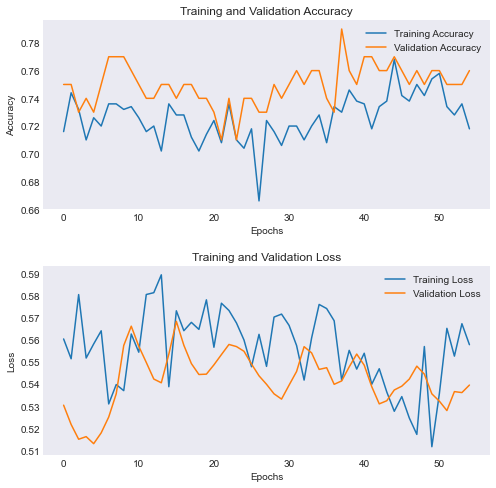

1/1 [==============================] - 0s 4ms/step - loss: 0.5416 - accuracy: 0.7100


[+] {'loss': 0.5416223406791687, 'accuracy': 0.7099999785423279} 


Epoch 1/600
1/1 [==============================] - 1s 904ms/step - loss: 0.5541 - accuracy: 0.7320 - val_loss: 0.4866 - val_accuracy: 0.8000
Epoch 2/600
1/1 [==============================] - 1s 1s/step - loss: 0.5603 - accuracy: 0.7200 - val_loss: 0.4892 - val_accuracy: 0.8300
Epoch 3/600
1/1 [==============================] - 1s 821ms/step - loss: 0.5547 - accuracy: 0.7240 - val_loss: 0.4921 - val_accuracy: 0.8300
Epoch 4/600
1/1 [==============================] - 1s 849ms/step - loss: 0.6067 - accuracy: 0.6920 - val_loss: 0.4968 - val_accuracy: 0.7600
Epoch 5/600
1/1 [==============================] - 1s 600ms/step - loss: 0.5480 - accuracy: 0.7040 - val_loss: 0.4985 - val_accuracy: 0.7500
Epoch 6/600
1/1 [==============================] - 1s 552ms/step - loss: 0.5685 - accuracy: 0.6960 - val_loss: 0.4980 - val_accuracy: 0.7400
Ep

1/1 [==============================] - 1s 659ms/step - loss: 0.5392 - accuracy: 0.7520 - val_loss: 0.4731 - val_accuracy: 0.8200
Epoch 57/600
1/1 [==============================] - 1s 856ms/step - loss: 0.5306 - accuracy: 0.7060 - val_loss: 0.4699 - val_accuracy: 0.7900
Epoch 58/600
1/1 [==============================] - 1s 611ms/step - loss: 0.5489 - accuracy: 0.7180 - val_loss: 0.4669 - val_accuracy: 0.7800
Epoch 59/600
1/1 [==============================] - 1s 650ms/step - loss: 0.5447 - accuracy: 0.7180 - val_loss: 0.4646 - val_accuracy: 0.7800
Epoch 60/600
1/1 [==============================] - 1s 692ms/step - loss: 0.5534 - accuracy: 0.7400 - val_loss: 0.4644 - val_accuracy: 0.7800
Epoch 61/600
1/1 [==============================] - 1s 702ms/step - loss: 0.5621 - accuracy: 0.7260 - val_loss: 0.4703 - val_accuracy: 0.7900
Epoch 62/600
1/1 [==============================] - 1s 542ms/step - loss: 0.5567 - accuracy: 0.7360 - val_loss: 0.4736 - val_accuracy: 0.7900
Epoch 63/600
1/1 [=

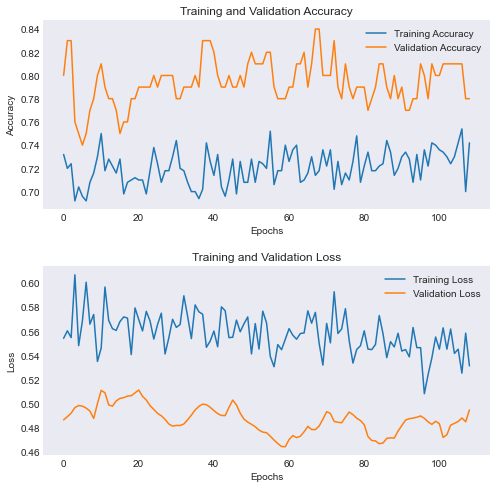

1/1 [==============================] - 0s 18ms/step - loss: 0.5388 - accuracy: 0.7400


[+] {'loss': 0.5388497710227966, 'accuracy': 0.7400000095367432} 


Epoch 1/600
1/1 [==============================] - 1s 928ms/step - loss: 0.5633 - accuracy: 0.7080 - val_loss: 0.4765 - val_accuracy: 0.7900
Epoch 2/600
1/1 [==============================] - 1s 1s/step - loss: 0.5460 - accuracy: 0.7200 - val_loss: 0.4720 - val_accuracy: 0.7700
Epoch 3/600
1/1 [==============================] - 1s 839ms/step - loss: 0.5638 - accuracy: 0.7220 - val_loss: 0.4674 - val_accuracy: 0.7700
Epoch 4/600
1/1 [==============================] - 1s 889ms/step - loss: 0.5901 - accuracy: 0.7220 - val_loss: 0.4720 - val_accuracy: 0.7800
Epoch 5/600
1/1 [==============================] - 1s 646ms/step - loss: 0.5439 - accuracy: 0.7340 - val_loss: 0.4875 - val_accuracy: 0.7800
Epoch 6/600
1/1 [==============================] - 1s 679ms/step - loss: 0.5874 - accuracy: 0.7020 - val_loss: 0.4931 - val_accuracy: 0.7800
E

1/1 [==============================] - 1s 579ms/step - loss: 0.5377 - accuracy: 0.7480 - val_loss: 0.4656 - val_accuracy: 0.7600
Epoch 57/600
1/1 [==============================] - 1s 629ms/step - loss: 0.5514 - accuracy: 0.7280 - val_loss: 0.4668 - val_accuracy: 0.7600
Epoch 58/600
1/1 [==============================] - 1s 516ms/step - loss: 0.5237 - accuracy: 0.7480 - val_loss: 0.4664 - val_accuracy: 0.7600
Epoch 59/600
1/1 [==============================] - 1s 664ms/step - loss: 0.5475 - accuracy: 0.7580 - val_loss: 0.4676 - val_accuracy: 0.7600
Epoch 60/600
1/1 [==============================] - 0s 481ms/step - loss: 0.5424 - accuracy: 0.7520 - val_loss: 0.4676 - val_accuracy: 0.7800
Epoch 61/600
1/1 [==============================] - 0s 367ms/step - loss: 0.5598 - accuracy: 0.7520 - val_loss: 0.4673 - val_accuracy: 0.7800
Epoch 62/600
1/1 [==============================] - 0s 447ms/step - loss: 0.5324 - accuracy: 0.7320 - val_loss: 0.4678 - val_accuracy: 0.7800
Epoch 63/600
1/1 [=

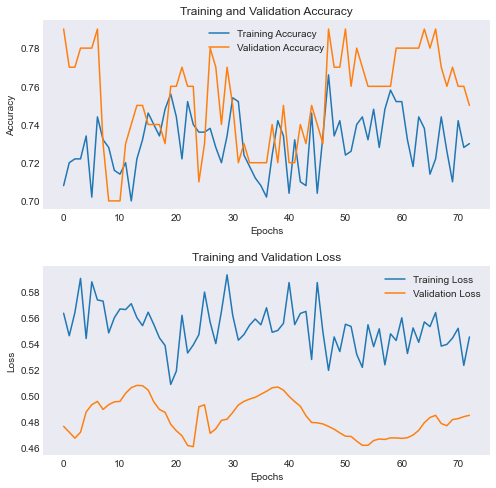

1/1 [==============================] - 0s 8ms/step - loss: 0.5498 - accuracy: 0.7100


[+] {'loss': 0.5498310923576355, 'accuracy': 0.7099999785423279} 


Epoch 1/600
1/1 [==============================] - 1s 640ms/step - loss: 0.5948 - accuracy: 0.7000 - val_loss: 0.4658 - val_accuracy: 0.7800
Epoch 2/600
1/1 [==============================] - 1s 682ms/step - loss: 0.5723 - accuracy: 0.7120 - val_loss: 0.4718 - val_accuracy: 0.7500
Epoch 3/600
1/1 [==============================] - 1s 719ms/step - loss: 0.5567 - accuracy: 0.7120 - val_loss: 0.4817 - val_accuracy: 0.7800
Epoch 4/600
1/1 [==============================] - 1s 577ms/step - loss: 0.5889 - accuracy: 0.7000 - val_loss: 0.4800 - val_accuracy: 0.8000
Epoch 5/600
1/1 [==============================] - 1s 701ms/step - loss: 0.5291 - accuracy: 0.7520 - val_loss: 0.4870 - val_accuracy: 0.7900
Epoch 6/600
1/1 [==============================] - 1s 534ms/step - loss: 0.5431 - accuracy: 0.7260 - val_loss: 0.5105 - val_accuracy: 0.8000

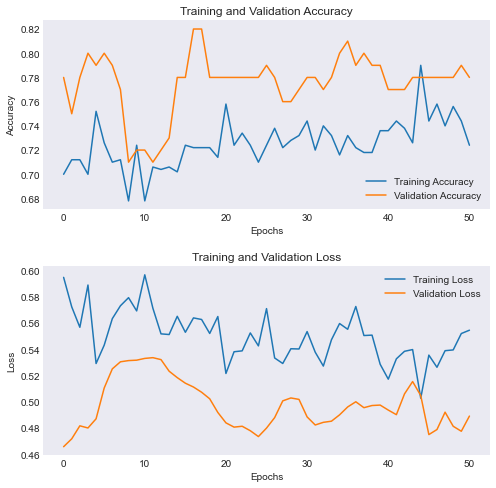

1/1 [==============================] - 0s 5ms/step - loss: 0.5542 - accuracy: 0.6800


[+] {'loss': 0.55423504114151, 'accuracy': 0.6800000071525574} 




In [24]:
HISTORIES = [] #loss and accuracy stored
RESULTS = {}

skf = StratifiedKFold(n_splits=6)

for train_index, val_index in skf.split(features, labels):
    
    # get features and labels for training and validation set
    train_features, val_features = features.iloc[train_index], features.iloc[val_index]
    train_labels, val_labels= labels.iloc[train_index], labels.iloc[val_index]
    
    # get features and labels for test set
    test_labels, test_features= test["Outcome"], test[numeric_columns]
    
    '''
    train_features, test_features, train_labels, test_labels = train_test_split(train_features, 
                                                                                train_labels, 
                                                                                test_size=0.166, 
                                                                                random_state=13
                                                                               )
    '''
    
    # get dataset from dataframe for training and validation
    batch_size = 500
    train_ds = df_to_dataset(train_features, targets = train_labels, batch_size=batch_size)
    val_ds = df_to_dataset(val_features, targets = val_labels, shuffle=False, batch_size=100)    
    
    # train the model and save the values (loss and accuracy) returned by model.fit in HISTORIES list
    # this is for training and validation data
    HISTORIES.append(model.fit(train_ds, validation_data=val_ds, epochs=600, callbacks=CALLBACKS, class_weight=None,
    sample_weight=None))
    plot_metrics(HISTORIES[-1].history, len(HISTORIES), epochs=len(HISTORIES[-1].history["loss"]))
    
    # get dataset from dataframe for testing
    test_ds = df_to_dataset(test_features, targets = test_labels, shuffle=False, batch_size=100)
    
    # evaluate the model on test set
    result = model.evaluate(test_ds)
    
    # save the test result for current experiment (current fold)
    for k, r in zip(model.metrics_names, result):
        if k not in RESULTS.keys():
            RESULTS[k] = []
        RESULTS[k].append(r)
    print("\n\n[+]", dict(zip(model.metrics_names, result)), "\n\n")
    

In [25]:
model.save("DiabetesModel", overwrite=True, include_optimizer=True, save_format='tf')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: DiabetesModel\assets
Model: "dia_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  192       
_________________________________________________________________
dense_1 (Dense)              multiple                  216       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  600       
_________________________________________________________________
dropout_1 (Dropout)          multiple               

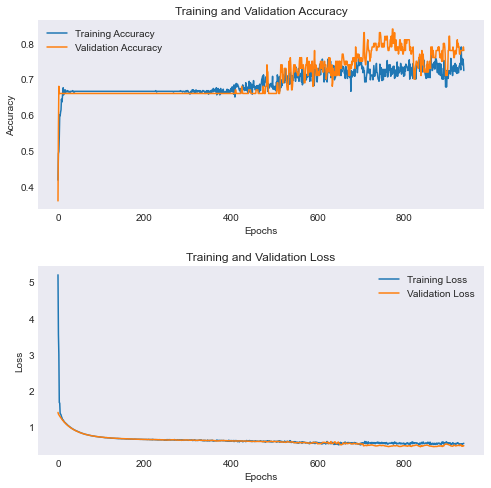

In [26]:
histories = {}
for key in HISTORIES[0].history.keys():
    histories[key] = []
    for history in HISTORIES:
        histories[key].extend(history.history[key])
    
plot_metrics(histories, 0, epochs=len(histories["loss"]))

In [27]:
def plot_evaluation(result):
    acc = result["accuracy"]
    loss = result["loss"]
    
    epochs_range = range(len(loss))
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'hspace': 0.3})
    
    ax[0].plot(epochs_range, acc, label='Test Accuracy')    
    ax[0].legend()
    ax[0].set_xlabel('Test')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy evaluation')
    
    ax[1].plot(epochs_range, loss, label='Test Loss')
    ax[1].legend()
    ax[1].set_xlabel('Test')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Loss Evaluation')
    
    fig.savefig("Result", dpi=fig.dpi)
    plt.show()
    plt.close()

In [28]:
RESULTS

{'loss': [0.5385415554046631,
  0.543521523475647,
  0.5416223406791687,
  0.5388497710227966,
  0.5498310923576355,
  0.55423504114151],
 'accuracy': [0.7099999785423279,
  0.7699999809265137,
  0.7099999785423279,
  0.7400000095367432,
  0.7099999785423279,
  0.6800000071525574]}

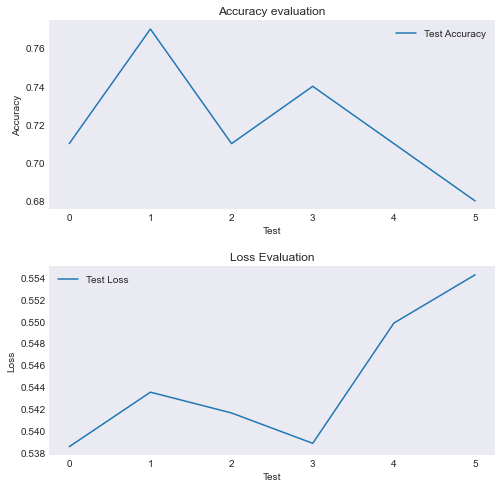

In [29]:
plot_evaluation(RESULTS)